In [1]:
import os
from tqdm import tqdm
import cv2
import multiprocessing

import sys
sys.path.append('/home/rwollman/MyProjects/AH/Repos/dredFISH')

from metadata import Metadata
import matplotlib.pyplot as plt
from dredFISH.Processing.Section import *
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter
dataset_path = '/orangedata/Images2024/Zach/MouseBrainAtlas/WTM02_3.1.A_2.3.B_3.3.D_1.2.E_2024Apr01'
image_metadata = Metadata(dataset_path)


2024-04-12 12:05:59,750 [INFO] WRITING LOG OUTPUT TO /home/rwollman/.cellpose/run.log


In [2]:
sorted([i for i in image_metadata.acqnames if 'ybe21' in i])

['Hybe21_69', 'Hybe21_70', 'Hybe21_71', 'Hybe21_72']

In [3]:
sorted([i for i in image_metadata.acqnames if 'rip21' in i])

['Strip21_65', 'Strip21_66', 'Strip21_67', 'Strip21_68']

In [103]:
  
parameters = {}
parameters['acq_FF'] = False
parameters['acq_constant'] = False

parameters['use_FF'] = True
parameters['use_constant'] = False

parameters['fit_FF'] = False
parameters['fit_constant'] = False

parameters['smooth_FF'] = False
parameters['smooth_constant'] = False

parameters['clip_FF'] = False
parameters['clip_constant'] = False

parameters['FF_poly_degrees'] = 5
parameters['constant_poly_degrees'] = 5

parameters['post_strip_FF'] = True
parameters['process_img_before_FF'] = False
parameters['debug'] = False
parameters['FF_n_cpu'] = 1

acq = 'Hybe21_70'
# bkg_acq = 'Strip21_66'
bkg_acq = ''
channel = 'FarRed'

FF_org,constant = generate_FF_parallel(image_metadata,acq=acq,channel=channel,bkg_acq=bkg_acq,parameters=parameters,verbose=True)


2024 April 12 13:31:02 Generating FlatField Hybe21_70 FarRed:   0%|          | 0/283 [00:00<?, ?it/s]

2024 April 12 13:31:02 Generating FlatField Hybe21_70 FarRed: 100%|██████████| 283/283 [01:35<00:00,  2.97it/s]


In [94]:
# remove hot pixels
# FF_hotpixel = FF_org.numpy().copy()
# FF = median_filter(FF_hotpixel,10)

In [104]:
FF = FF_org.numpy().copy()


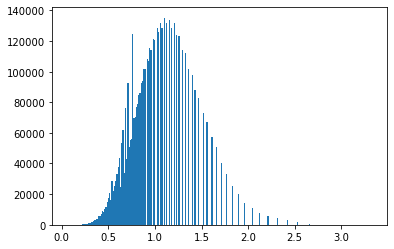

In [118]:
plt.hist(FF.flatten(),bins=250);

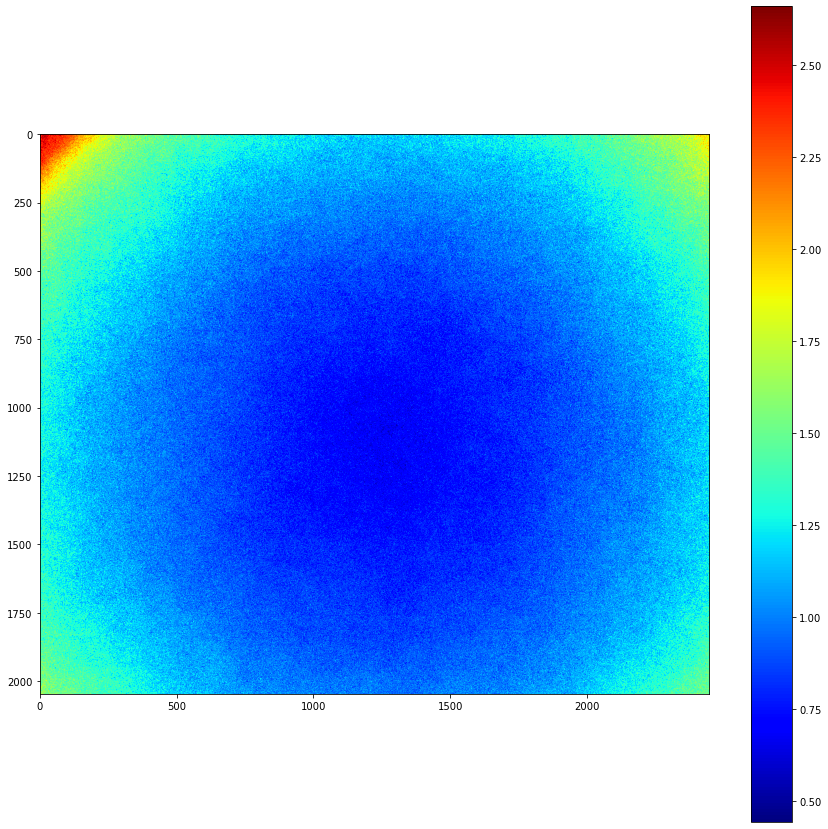

In [116]:
plt.figure(figsize=(15,15))
vmin,vmax = np.percentile(FF.ravel(),[1,99.99])
plt.imshow(FF,vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar()
plt.show()

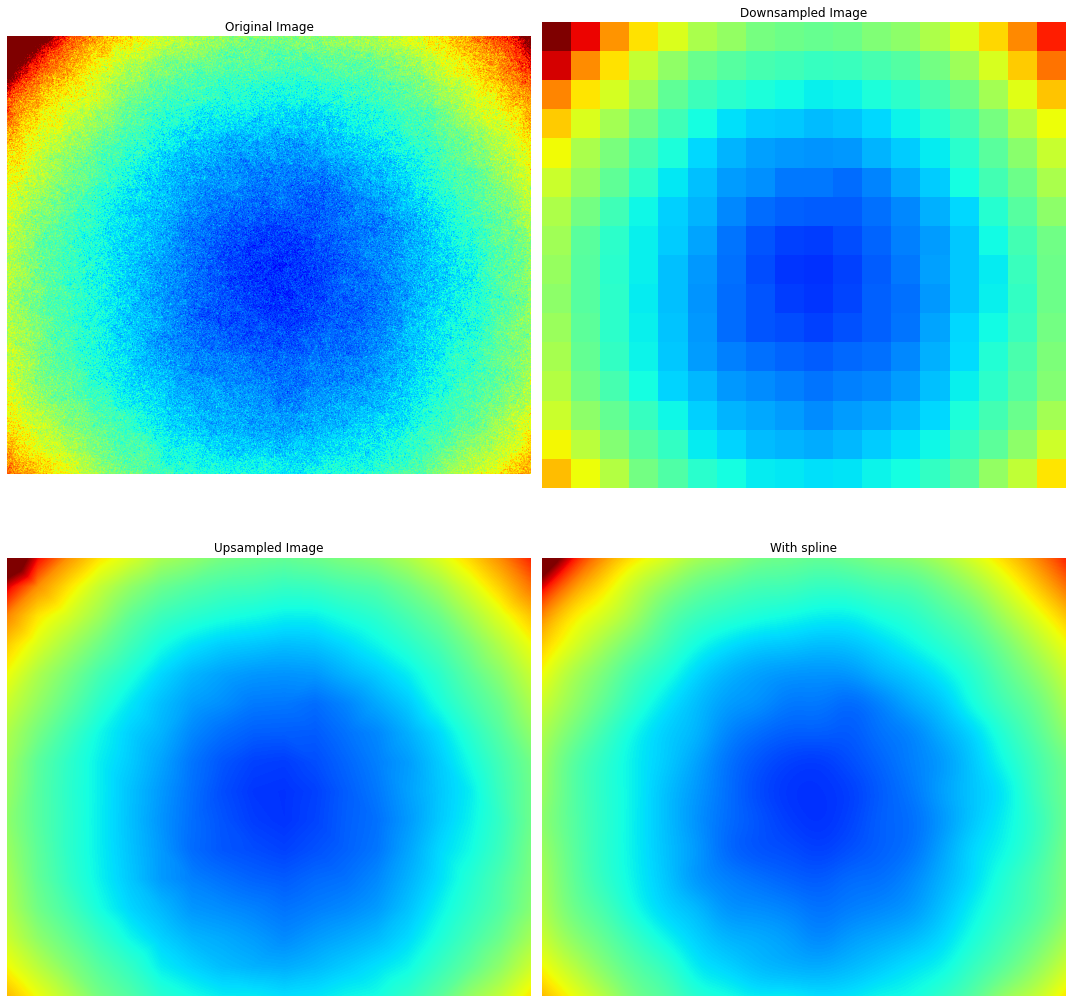

In [143]:
from skimage.measure import block_reduce
from scipy.ndimage import zoom
from matplotlib import pyplot as plt

# Downsample the image using block processing
block_size = np.array([64, 68])*2
img_sml = block_reduce(FF, tuple(block_size), np.mean)

from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline

# Create coordinate grid for original and downsampled image
x = np.arange(FF.shape[1])
y = np.arange(FF.shape[0])
x_sml, y_sml = np.meshgrid(np.linspace(0, FF.shape[1], img_sml.shape[1]), np.linspace(0, FF.shape[0], img_sml.shape[0]))

# Flatten the downsampled image and coordinate grids for griddata input
points = np.vstack((y_sml.ravel(), x_sml.ravel())).T
values = img_sml.ravel()

# Create coordinate grid for the upsampled image
grid_x, grid_y = np.meshgrid(x, y)

# Upsample using linear interpolation with extrapolation
img_big = griddata(points, values, (grid_y, grid_x), method='linear', fill_value=0)

# Creating an interpolator object with sorted values
interpolator = RectBivariateSpline(y_sml[:, 0], x_sml[0],  img_sml, kx=2, ky=2)

# Interpolating and extrapolating
img_big_spline  = interpolator.ev(grid_y, grid_x)

# Plotting img, img_sml, and img_big next to each other
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs=axs.flatten()
vmin, vmax = np.percentile(FF.ravel(), [1, 99])  # Same scale for all images

axs[0].imshow(FF, vmin=vmin, vmax=vmax, cmap='jet')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(img_sml, vmin=vmin, vmax=vmax, cmap='jet')
axs[1].set_title('Downsampled Image')
axs[1].axis('off')

axs[2].imshow(img_big, vmin=vmin, vmax=vmax, cmap='jet')
axs[2].set_title('Upsampled Image')
axs[2].axis('off')

axs[3].imshow(img_big_spline, vmin=vmin, vmax=vmax, cmap='jet')
axs[3].set_title('With spline')
axs[3].axis('off')

plt.tight_layout()
plt.show()


(32, 36)

In [135]:
x_sml[0].shape

(36,)

In [40]:
values_sorted.shape

(1152,)

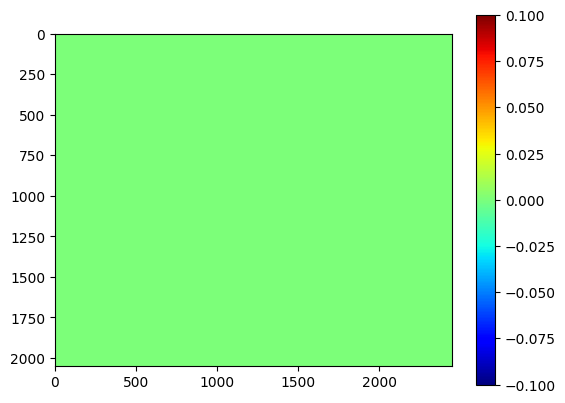

In [7]:
img = constant.numpy()
vmin,vmax = np.percentile(img.ravel(),[1,99])
plt.imshow(np.clip(img,vmin,vmax),cmap='jet')
plt.colorbar()
plt.show()